In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import cv2
import copy

%matplotlib inline

In [2]:
from augmentation import do_augmentation, get_seed
from dataset import do_segment_mask
# seed = get_seed()
# print(seed)

In [3]:
train_label = pd.read_csv('data/raw/train.csv')

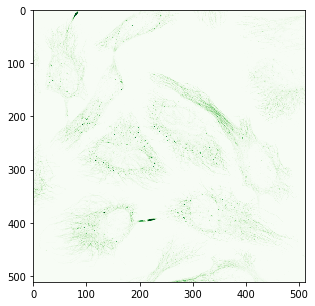

In [4]:
random_id = 232

img_file = 'data/raw/train/%s_green.png'%train_label.Id[random_id]
img = plt.imread(img_file)
fig = plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='Greens')

In [109]:
def do_segment_mask(img, window_size=16):
    """create cell masks, return numpy.array with 0-1
    """
    #step1: binary thresholding, but lots of isolated noises
    #mask = (img > np.percentile(img, 50)).astype(np.float32)
    #step2: smoothing(or local averaging), to denoise
    kernel = np.ones((window_size, window_size),np.float32) / window_size**2 #5x5 windows
    smoothed_mask = cv2.filter2D(img, ddepth=-1, kernel=kernel)#
    #step3: binary threshold again
    final_mask = (smoothed_mask > np.percentile(smoothed_mask, 75)).astype(np.float32)
    return final_mask

#test examples
for i in range(30):
    img_file = 'data/raw/train/%s_green.png'%train_label.Id[i]
    img = plt.imread(img_file)
    plt.imshow(img, cmap='Greens')
    plt.savefig('data/processed/mask/%d_raw.png'%i)
    plt.imshow(do_segment_mask(img, window_size=16), cmap='binary')
    plt.savefig('data/processed/mask/%d_mask.png'%i)

In [17]:
for i in range(100, 200):
    img_file = 'data/raw/train/%s_green.png'%train_label.Id[i]
    img = plt.imread(img_file)
    img = np.concatenate((img.reshape(1, 512, 512), img.reshape(1,512,512), img.reshape(1,512,512), img.reshape(1,512,512)),axis=0)
    
    mask = do_segment_mask(img[1, :, :], window_size=16)
    
    img, mask = do_augmentation(img, mask)
    

do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmentation:  (4, 512, 512) (512, 512)
do_augmenta

## cut and get regions

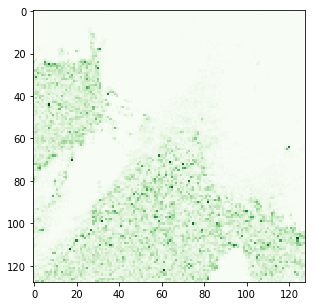

In [174]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(patches[13][1], cmap='Greens')

In [162]:
import itertools
from collections import namedtuple


def area(coord1, coord2):  # returns None if rectangles don't intersect
    Rectangle = namedtuple('Rectangle', 'xmin xmax ymin ymax')
    min_x1, max_x1, min_y1, max_y1 = coord1[0][0], coord1[0][1], coord1[1][0], coord1[1][1]
    min_x2, max_x2, min_y2, max_y2 = coord2[0][0], coord2[0][1], coord2[1][0], coord2[1][1]
    a = Rectangle(min_x1, max_x1, min_y1, max_y1)
    b = Rectangle(min_x2, max_x2, min_y2, max_y2)
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    return 0.0

def is_overlap(coord1, coord2):
    """
    e.g.input: [(58, 186), (163, 291)], [(57, 185), (165, 293)]
    """
    min_x1, max_x1, min_y1, max_y1 = coord1[0][0], coord1[0][1], coord1[1][0], coord1[1][1]
    min_x2, max_x2, min_y2, max_y2 = coord2[0][0], coord2[0][1], coord2[1][0], coord2[1][1]
    if min_x1 > max_x2 or max_x1 < min_x2:
        return False
    if min_y1 > max_y2 or max_y1 < min_y2:
        return False
    return True

def convolve(img, kernel_size=3):
    """
    img: size 512x512
    return a list of patches with size: kernel_size
    return brightest N patches
    """
    # crop
    img_size = img.shape[0]
    l0 = np.arange(0, img_size-kernel_size+1)
    l1 = list(itertools.product(l0, l0))
    patches = [([(i,i+kernel_size), (j,j+kernel_size)], img[i:i+kernel_size, j:j+kernel_size]) for i,j in l1]
    
    # sort by brightness
    idx_list = np.argsort([patch[1].mean() for patch in patches])[::-1]
    output = []
    cnt = 0
    for idx in idx_list:
        patch = patches[idx]
        coord, patch_img = patch[0], patch[1]
        if output==[]:
            output.append(patch)
            cnt += 1
        elif not any([area(coord, patch_other[0])>0.5*kernel_size**2 for patch_other in output]):
            output.append(patch)
            cnt += 1
        if cnt >= 20:
            break
    return output

In [163]:
patches = convolve(img, kernel_size=128)

In [164]:
for patch in patches:
    print(patch[0])

[(58, 186), (163, 291)]
[(137, 265), (70, 198)]
[(139, 267), (4, 132)]
[(127, 255), (129, 257)]
[(78, 206), (80, 208)]
[(83, 211), (212, 340)]
[(180, 308), (38, 166)]
[(35, 163), (113, 241)]
[(233, 361), (69, 197)]
[(177, 305), (105, 233)]
[(360, 488), (317, 445)]
[(235, 363), (132, 260)]
[(167, 295), (164, 292)]
[(23, 151), (203, 331)]
[(135, 263), (370, 498)]
[(132, 260), (306, 434)]
[(72, 200), (270, 398)]
[(317, 445), (70, 198)]
[(72, 200), (373, 501)]
[(208, 336), (384, 512)]


In [7]:
#color = '_red.png'#'_green.png'

random_file_list = np.random.choice(archive.namelist(), 5)
random_file_list = [[random_file.split('_')[0]+color for color in ['_red.png', '_green.png', '_blue.png', '_yellow.png']] 
                    for random_file in random_file_list]
random_file_list = list(np.ravel(random_file_list))
#for f in random_file_list:
#    print(f)
#print(random_file_list)

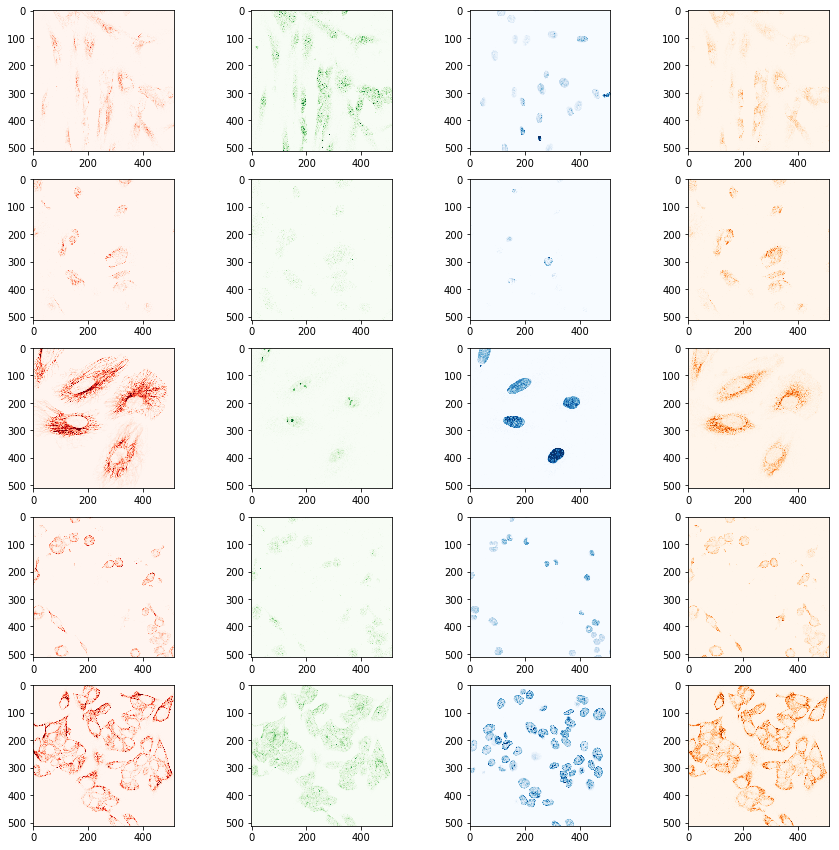

In [14]:
fig=plt.figure(figsize=(15, 15))
for i, f in enumerate(random_file_list):
    ax = fig.add_subplot(5, 4, i+1)
    img_file = archive.open(f)
    img = plt.imread(img_file)
    if 'red' in f:
        cmap = 'Reds'
    elif 'green' in f:
        cmap = 'Greens'
    elif 'blue' in f:
        cmap = 'Blues'
    elif 'yellow' in f:
        cmap = 'Oranges'
    plt.imshow(img, cmap=cmap)

## label and sub

In [11]:
train_label = pd.read_csv('data/raw/train.csv')

In [19]:
train_label.head(2)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0


In [16]:
train_label.loc[1, 'Target']

'7 1 2 0'

In [17]:
sample_sub = pd.read_csv('data/raw/sample_submission.csv')

In [21]:
sample_sub.head(2)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
